# Periodic Boundary Conditions

In [150]:
import numpy as np
from scipy.sparse import csc_array

import matplotlib.pyplot as plt
import matplotlib as mpl

# default parameters of the plot layout
plt.rcParams["text.usetex"] = True  # use latex
plt.rcParams["font.size"] = 13
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.constrained_layout.use"] = True

from qs_mps.applications.Z2.exact_hamiltonian import *
from qs_mps.sparse_hamiltonians_and_operators import diagonalization, sparse_magnetization, sparse_pauli_x, sparse_pauli_z
from qs_mps.mps_class import MPS

## Direct Hamiltonian

In [151]:
def direct_ham(l, L, g, U: int=0, cx: list=[], cy: list=[]):
    # degrees of freedom
    dof = l*(L+1) + l*L
    
    # initialize
    O = csc_array((2**dof, 2**dof), dtype=complex)
    I = identity(2**dof, dtype=complex)
    H_sigmas = O
    H_taus = O
    H_plaquettes = O
    H_gauss = O
    
    # charges
    charges = np.ones((l,L+1))
    if len(cx) != 0:
        charges[cy[0],cx[0]] = -1
        charges[cy[1],cx[1]] = -1

    # horizontal terms
    for i in range(l*L):
        H_taus += sparse_pauli_x(n=i, L=dof)

    # vertical terms
    for i in range(l*L,l*(L+1)+l*L):
        H_sigmas += sparse_pauli_x(n=i, L=dof)

    # plaquettes terms
    for j in range(l):
        for i in range(L):
            H_plaquettes += sparse_pauli_z(n=i+j*L, L=dof) @ sparse_pauli_z(n=(i+L+j*(L))%(l*L), L=dof) @ sparse_pauli_z(n=(i+l*L+j*(L+1)), L=dof) @ sparse_pauli_z(n=(i+l*L+1+j*(L+1)), L=dof)

    # gauss law on the left
    i = 0
    for j in range(1,l+1):
        G_j = (sparse_pauli_x(n=i+l*L+(j-1)*(L+1), L=dof) @ sparse_pauli_x(n=(i+L+(j-1)*(L))%(l*L), L=dof) @ sparse_pauli_x(n=i+l*L+((j)*(L+1))%(l*(L+1)), L=dof))
        H_gauss += (G_j - I * charges[j%l,i]) @ (G_j - I * charges[j%l,i])

    # gauss law on the right
    i = L
    for j in range(1,l+1):
        G_j = (sparse_pauli_x(n=(i+l*L+(j-1)*(L+1)), L=dof) @ sparse_pauli_x(n=(i-1+L+(j-1)*(L))%(l*L), L=dof) @ sparse_pauli_x(n=i+l*L+((j)*(L+1))%(l*(L+1)), L=dof))
        H_gauss += (G_j - I * charges[j%l,i]) @ (G_j - I * charges[j%l,i])

    # gauss law on the bulk
    for i in range(1,L):
        for j in range(1,l+1):
            G_j = (sparse_pauli_x(n=i+l*L+(j-1)*(L+1), L=dof) @ sparse_pauli_x(n=(i-1+L+(j-1)*(L))%(l*L), L=dof) @ sparse_pauli_x(n=i+l*L+((j)*(L+1))%(l*(L+1)), L=dof) @ sparse_pauli_x(n=(i+L+(j-1)*(L))%(l*L), L=dof))
            H_gauss += (G_j - I * charges[j%l,i]) @ (G_j - I * charges[j%l,i])

    return - g * H_sigmas - g * H_taus - 1/g * H_plaquettes + U * H_gauss

In [152]:
l, L = 2,2
dof_gauss = l*(L+1)
for j in range(l):
    for i in range(L):
        print(i+j*L, (i+L+j*(L))%(l*L), (i+l*L+j*(L+1)), (i+l*L+1+j*(L+1)))

0 2 4 5
1 3 5 6
2 0 7 8
3 1 8 9


In [153]:
l, L = 2,2
i = 0
for j in range(1,l+1):
    print((i+l*L+(j-1)*(L+1)), (i+L+(j-1)*(L))%(l*L), (i+l*L+((j)*(L+1))%(l*(L+1))))

4 2 7
7 0 4


In [154]:
l, L = 2,2
i = L
for j in range(1,l+1):
    print((i+l*L+(j-1)*(L+1)), (i-1+L+(j-1)*(L))%(l*L), (i+l*L+((j)*(L+1))%(l*(L+1))))

6 3 9
9 1 6


In [155]:
l, L = 3,3
for i in range(1,L):
    for j in range(1,l+1):
        print((i+l*L+(j-1)*(L+1)), (i-1+L+(j-1)*(L))%(l*L), (i+l*L+((j)*(L+1))%(l*(L+1))), (i+L+(j-1)*(L))%(l*L))

10 3 14 4
14 6 18 7
18 0 10 1
11 4 15 5
15 7 19 8
19 1 11 2


In [156]:
l = 2
L = 2
g = 1
dof_gauss = l*L + 1
H_dir = direct_ham(l,L,g, U=100)
e, v = diagonalization(H_dir, sparse=False)
print(e[(2**dof_gauss)-2:(2**dof_gauss)+2], len(e))


[  6.87365913   6.90551107 791.25210492 791.25210492] 1024


## Dual Hamiltonian

In [157]:
def dual_ham(l,L,g, cx: list=[], cy: list=[]):
    # degrees of freedom
    dof = l*L + 1

    # charges
    charges = np.ones((l,L+1))
    if len(cx) != 0:
        charges[cy[0],cx[0]] = -1
        charges[cy[1],cx[1]] = -1
    prod_charges = [1] + np.prod(charges[1:], axis=1).tolist()
    
    # initialize
    O = csc_array((2**dof, 2**dof), dtype=complex)
    H_sigmas = O
    H_taus = O
    H_plaquettes = O

    # first column of sigma are local
    for i in range(l):
        H_sigmas += sparse_pauli_z(n=i*L, L=dof)
    
    # horizontal zz interactions, we exclude the last column of sigmas
    for j in range(l):
        for i in range(L-1):
            H_sigmas += sparse_pauli_z(n=i+j*L, L=dof) @ sparse_pauli_z(n=(i+1)+j*L, L=dof)

    # horizontal zz interactions, last column of sigmas
    for j in range(l):
        H_sigmas += np.prod(prod_charges[:(j+1)]) * sparse_pauli_z(n=j*L+L-1, L=dof) @ sparse_pauli_z(n=l*L, L=dof)

    # vertical zz interactions 
    for j in range(L):
        for i in range(l):
            H_taus += np.prod(charges[(i+1)%l,:(j+1)]) * sparse_pauli_z(n=i*L+j, L=dof) @ sparse_pauli_z(n=((i+1)%l)*L+j, L=dof)

    # plaquette terms
    for i in range(l*L):
        H_plaquettes += sparse_pauli_x(n=i, L=dof)

    return - g * H_sigmas - g * H_taus - 1/g * H_plaquettes

In [158]:
L = 2
l = 2
g = 1
dof = l*L + 1
H_dual = dual_ham(l,L,g)
e,v = diagonalization(H_dual, sparse=False)
print(e[(2**dof)-2:], len(e))

[6.87365913 6.90551107] 32


## Compare Direct and Dual

Computing g: 0.5
Computing g: 0.52
Computing g: 0.54
Computing g: 0.56
Computing g: 0.58
Computing g: 0.6
Computing g: 0.62
Computing g: 0.64
Computing g: 0.66
Computing g: 0.6799999999999999
Computing g: 0.7
Computing g: 0.72
Computing g: 0.74
Computing g: 0.76
Computing g: 0.78
Computing g: 0.8
Computing g: 0.8200000000000001
Computing g: 0.8400000000000001
Computing g: 0.86
Computing g: 0.88
Computing g: 0.9
Computing g: 0.9199999999999999
Computing g: 0.94
Computing g: 0.96
Computing g: 0.98
Computing g: 1.0
Computing g: 1.02
Computing g: 1.04
Computing g: 1.06
Computing g: 1.08
Computing g: 1.1
Computing g: 1.12
Computing g: 1.1400000000000001
Computing g: 1.1600000000000001
Computing g: 1.1800000000000002
Computing g: 1.2000000000000002
Computing g: 1.22
Computing g: 1.24
Computing g: 1.26
Computing g: 1.28
Computing g: 1.3
Computing g: 1.32
Computing g: 1.3399999999999999
Computing g: 1.3599999999999999
Computing g: 1.38
Computing g: 1.4
Computing g: 1.42
Computing g: 1.44
Compu

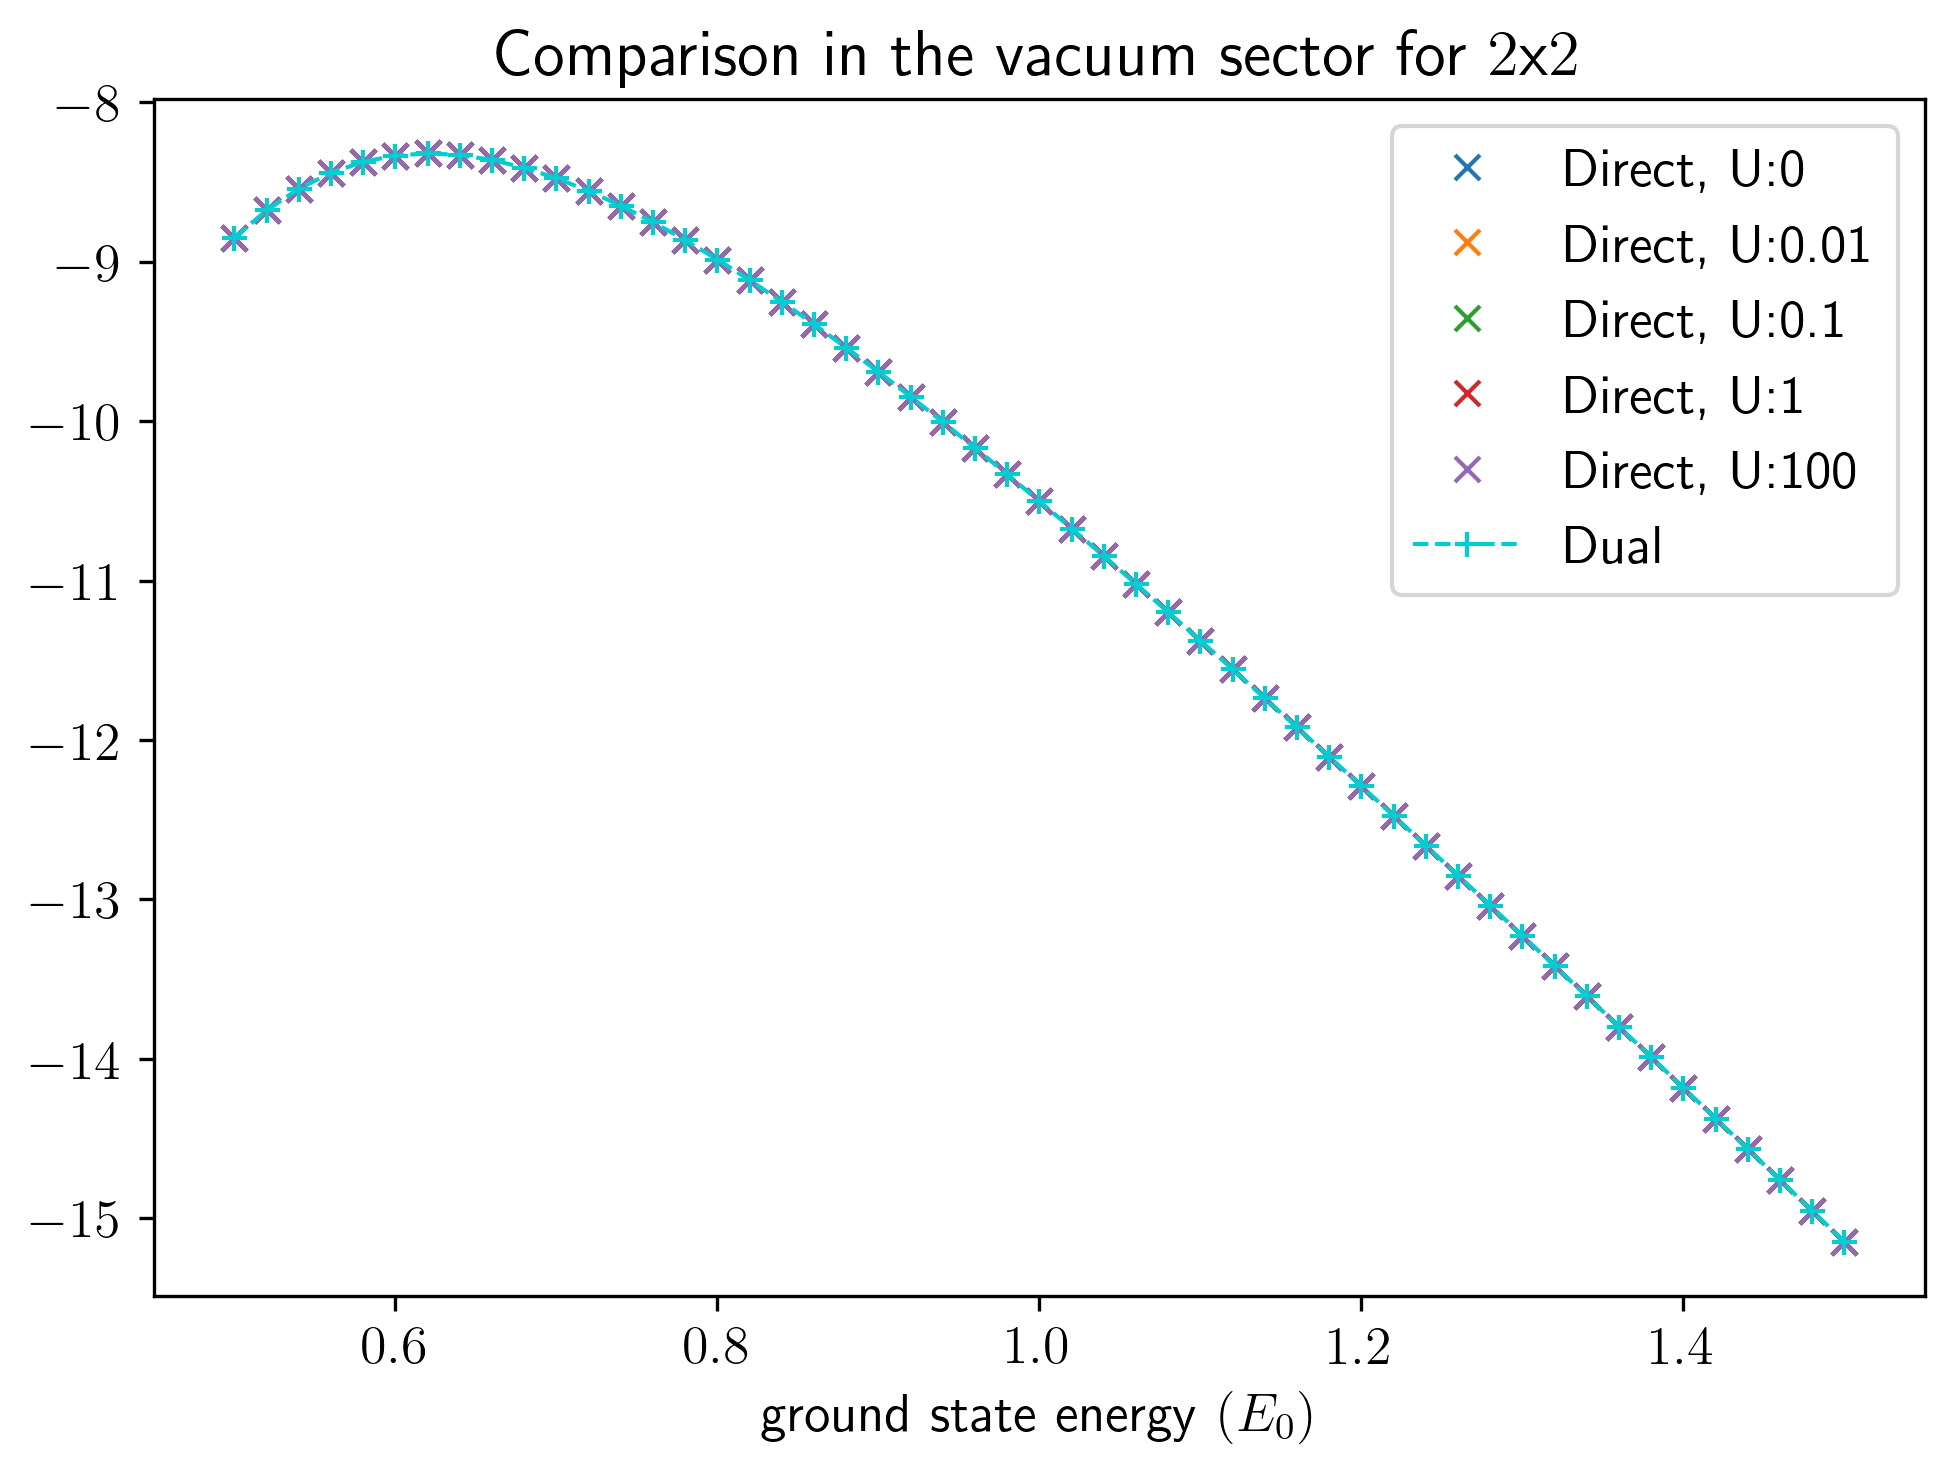

In [170]:
l, L = 2, 2
gs = np.linspace(0.5,1.5,51)
cx = [0,L]
cy = [l//2,l//2]
cx = []
cy = []

e_dual = []
for g in gs:
    H_dual = dual_ham(l,L,g,cx,cy)
    e,v = diagonalization(H_dual, sparse=True)
    e_dual.append(e[0])

Us = [0, 0.01, 0.1 , 1, 100]
for U in Us:
    e_dir = []
    for g in gs:
        print(f"Computing g: {g}")
        H_dir = direct_ham(l,L,g,U,cx,cy)
        e,v = diagonalization(H_dir, sparse=True)
        e_dir.append(e[0])

    plt.plot(gs,e_dir, 'x', label=f"Direct, U:{U}")
plt.plot(gs,e_dual, '+', linestyle='--', color='darkturquoise', linewidth=1, label="Dual")
if len(cx) == 0:
    plt.title(f"Comparison in the vacuum sector for ${l}$x${L}$")
else:    
    plt.title(f"Comparison in the $2$ particles sector for ${l}$x${L}$")
plt.xlabel("coupling term $(g)$")
plt.xlabel("ground state energy $(E_0)$")
plt.legend()

## MPO construction

In [160]:
def mpo_skeleton(l, aux_dim: int=None):
    """
    mpo_skeleton

    This function initializes the mpo tensor or shape (2+l,2+l,2**l,2**l)
    with O matrices. We add as well the identities in the first and last
    element of the mpo tensor.

    aux_dim: int - This auxiliary dimension represents how many rows and 
                columns we want in our MPO. By default None means that it adapts
                to the system under study. Fixing the auxiliary dimension is
                useful for known observables which will not need larger MPOs
    """
    I = identity(2**l, dtype=complex)
    O = csc_array((2**l, 2**l), dtype=complex)
    if aux_dim == None:
        skeleton = np.array(
            [[O.toarray() for i in range(2 + l)] for j in range(2 + l)]
        )
    else:
        skeleton = np.array(
            [[O.toarray() for i in range(aux_dim)] for j in range(aux_dim)]
        )
    skeleton[0, 0] = I.toarray()
    skeleton[-1, -1] = I.toarray()
    mpo = skeleton
    return mpo

def MPOPeriodicBoundaryConditions(l,L,g, cx: list=[], cy: list=[]):
    # degrees of freedom
    dof = l*L + 1

    # charges
    charges = np.ones((l,L+1))
    if len(cx) != 0:
        charges[cy[0],cx[0]] = -1
        charges[cy[1],cx[1]] = -1
    prod_charges = np.prod(charges, axis=1).tolist()

    # initialize
    mpo = mpo_skeleton(l)
    mpo_list = []
    for mpo_site in range(L):
        # first row, for the zz horizontal interactions
        for n in range(l):
            mpo[0, n+1] = sparse_pauli_z(n=n, L=l).toarray()
        # last column, for the zz horizontal interactions
        for n in range(l):
            mpo[n+1, -1] = - g * sparse_pauli_z(n=n, L=l).toarray()
        # first row last column, for the "local" zz vertical interaction
        for n in range(l):
            coeff = np.prod(charges[(n+1)%l,:mpo_site+1])
            mpo[0,-1] += - g * coeff * (sparse_pauli_z(n=n, L=l).toarray() @ sparse_pauli_z(n=(n+1)%l, L=l).toarray())
        # first row last column, for the local z vertical terms on the left boundary
        if mpo_site == 0:
            for n in range(l):
                mpo[0,-1] += - g * sparse_pauli_z(n=n, L=l).toarray()
        # first row last column, for the local x plaquette terms
        for n in range(l):
            mpo[0,-1] += - 1/g * sparse_pauli_x(n=n, L=l).toarray()
    
        mpo_list.append(mpo)
        mpo = mpo_skeleton(l)
        
    # last column, add the extra degree of freedom with depends on the charges
    mpo = mpo_skeleton(1, aux_dim=(l+2))
    for n in range(l):
        coeff = np.prod(prod_charges[:n+1])
        mpo[n+1, -1] = - g * coeff * sparse_pauli_z(n=0, L=1).toarray()
    mpo_list.append(mpo)

    return mpo_list


In [161]:
l, L = 3, 2
charges = np.ones((l,L+1))
charges[l//2,0] = -1
charges[l//2,L] = -1
print(charges)
prod_charges = np.prod(charges, axis=1).tolist()
for mpo_site in range(L):
    for n in range(l):
        print(np.prod(charges[(n+1)%l,:mpo_site+1]), ((n+1)%l, mpo_site))


[[ 1.  1.  1.]
 [-1.  1. -1.]
 [ 1.  1.  1.]]
-1.0 (1, 0)
1.0 (2, 0)
1.0 (0, 0)
-1.0 (1, 1)
1.0 (2, 1)
1.0 (0, 1)


In [162]:
from qs_mps.utils import mpo_to_matrix, tensor_shapes
from qiskit.quantum_info import SparsePauliOp

l, L = 2, 2
g = 1
mpo_pbc = MPOPeriodicBoundaryConditions(l,L,g)
H = mpo_to_matrix(mpo_pbc)
e,v = diagonalization(H, sparse=True)
print(e)

[-10.50233679]


In [163]:
tensor_shapes(mpo_pbc)

(4, 4, 4, 4)
(4, 4, 4, 4)
(4, 4, 2, 2)


[(4, 4, 4, 4), (4, 4, 4, 4), (4, 4, 2, 2)]

## Comparison MPO with Exact Direct and Exact Dual

Computing g: 0.5
Computing g: 0.52
Computing g: 0.54
Computing g: 0.56
Computing g: 0.58
Computing g: 0.6
Computing g: 0.62
Computing g: 0.64
Computing g: 0.66
Computing g: 0.6799999999999999
Computing g: 0.7
Computing g: 0.72
Computing g: 0.74
Computing g: 0.76
Computing g: 0.78
Computing g: 0.8
Computing g: 0.8200000000000001
Computing g: 0.8400000000000001
Computing g: 0.86
Computing g: 0.88
Computing g: 0.9
Computing g: 0.9199999999999999
Computing g: 0.94
Computing g: 0.96
Computing g: 0.98
Computing g: 1.0
Computing g: 1.02
Computing g: 1.04
Computing g: 1.06
Computing g: 1.08
Computing g: 1.1
Computing g: 1.12
Computing g: 1.1400000000000001
Computing g: 1.1600000000000001
Computing g: 1.1800000000000002
Computing g: 1.2000000000000002
Computing g: 1.22
Computing g: 1.24
Computing g: 1.26
Computing g: 1.28
Computing g: 1.3
Computing g: 1.32
Computing g: 1.3399999999999999
Computing g: 1.3599999999999999
Computing g: 1.38
Computing g: 1.4
Computing g: 1.42
Computing g: 1.44
Compu

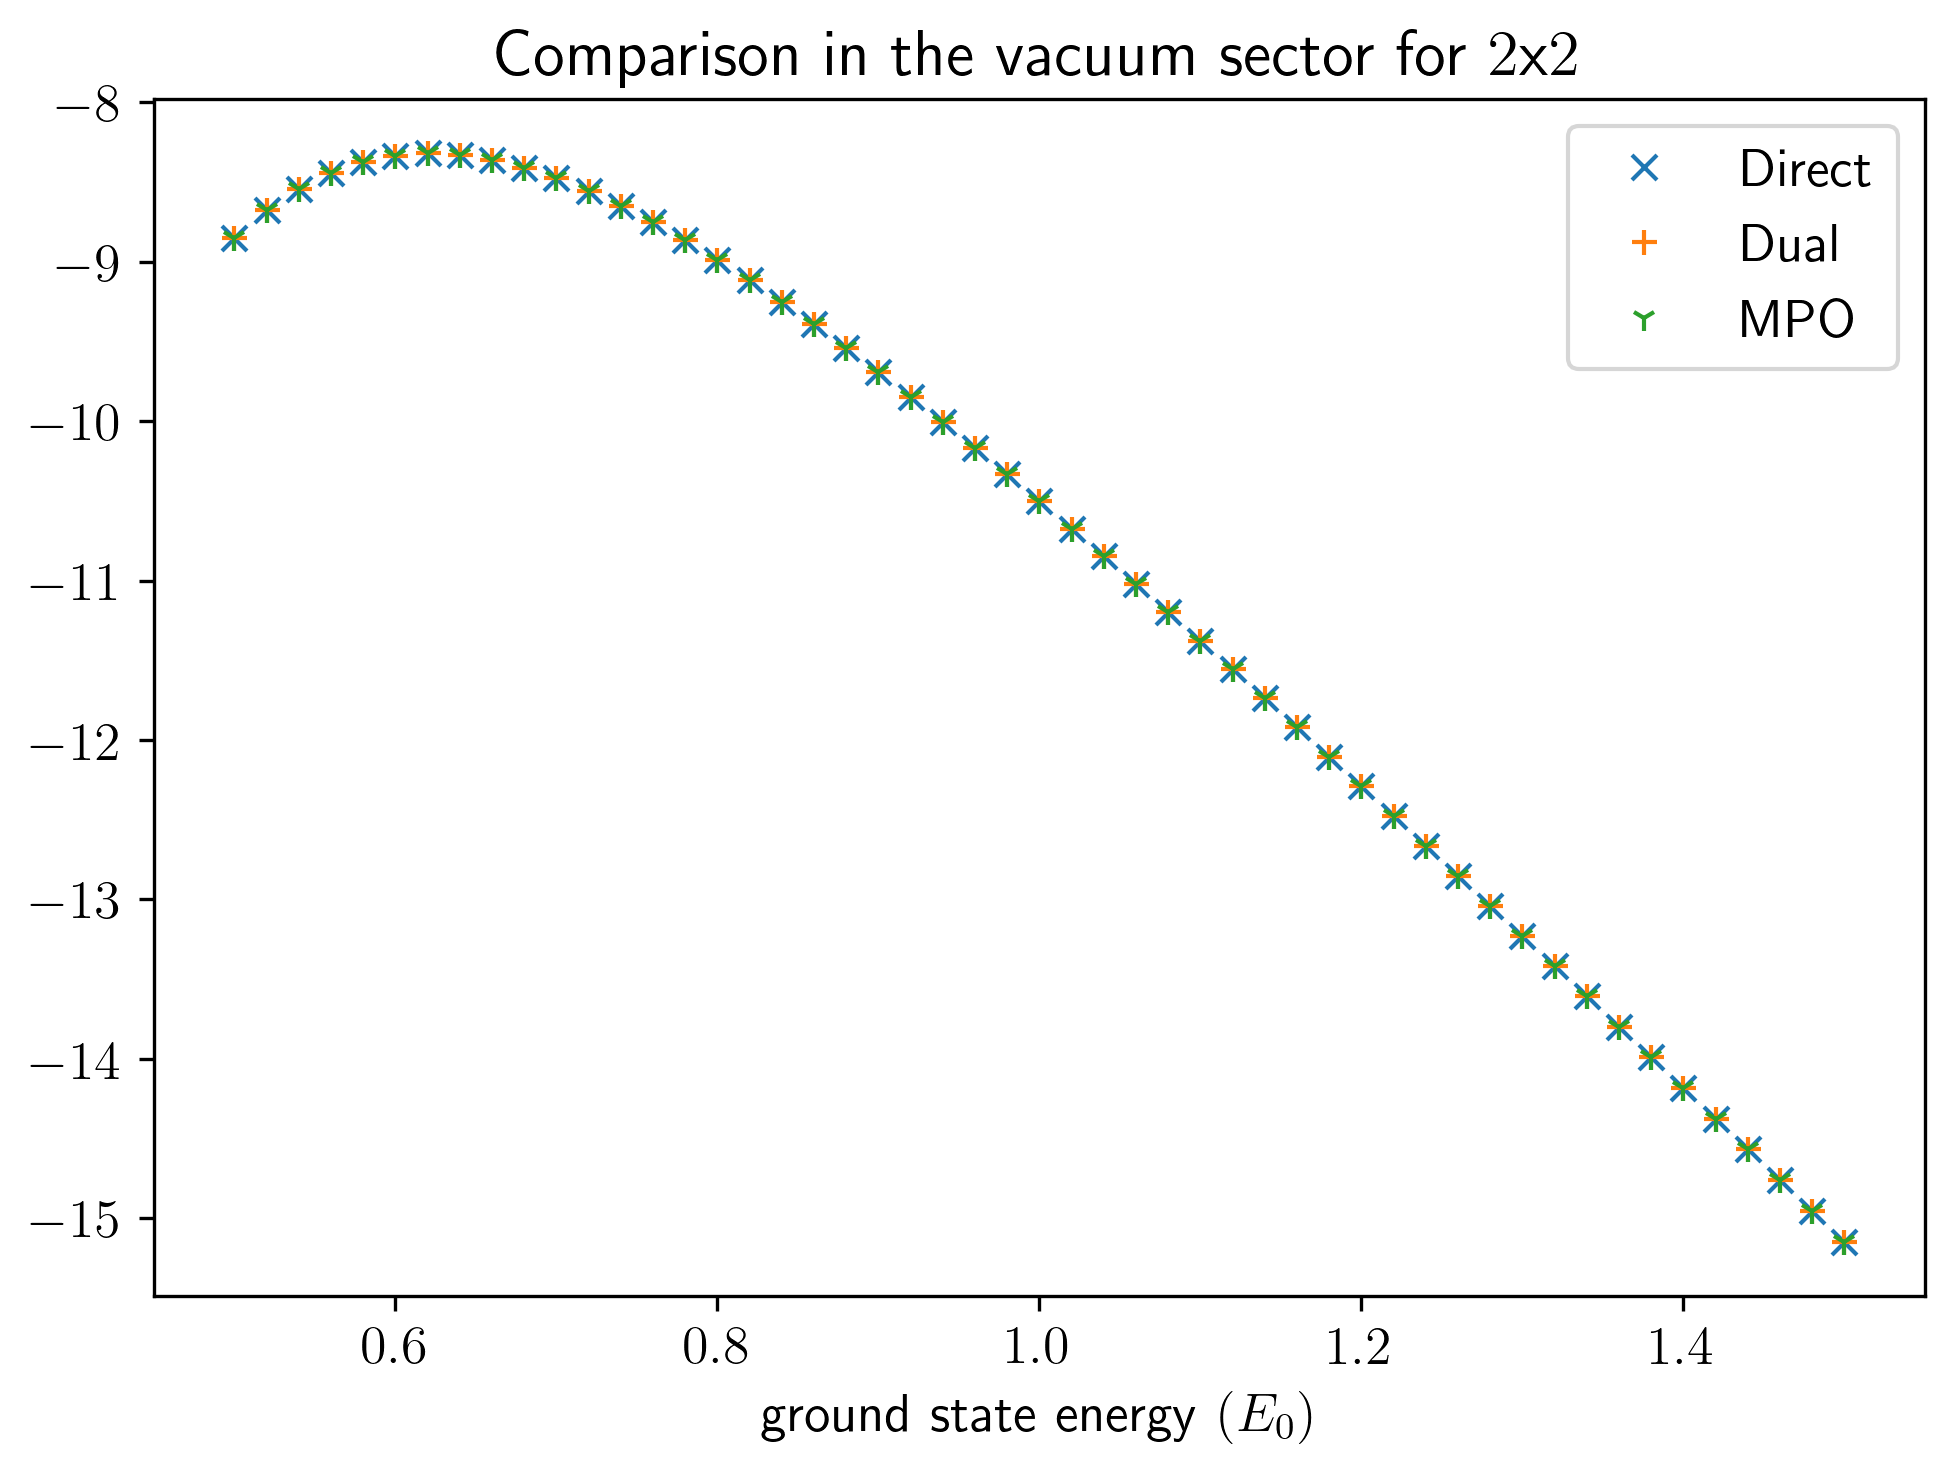

In [169]:
l, L = 2, 2
gs = np.linspace(0.5,1.5,51)
e_dir = []
e_dual = []
e_mpo = []
cx = [0,L]
cy = [l//2,l//2]
cx = []
cy = []
for g in gs:
    print(f"Computing g: {g}")
    H_dual = dual_ham(l,L,g,cx,cy)
    e,v = diagonalization(H_dual, sparse=True)
    e_dual.append(e[0])
    H_dir = direct_ham(l,L,g,Us[-1],cx,cy)
    e,v = diagonalization(H_dir, sparse=True)
    e_dir.append(e[0])
    mpo_pbc = MPOPeriodicBoundaryConditions(l,L,g,cx,cy)
    H_mpo = mpo_to_matrix(mpo_pbc)
    e,v = diagonalization(H_mpo, sparse=True)
    e_mpo.append(e[0])

plt.plot(gs,e_dir, 'x', label="Direct")
plt.plot(gs,e_dual, '+', label="Dual")
plt.plot(gs,e_mpo, '1', label="MPO")
if len(cx) == 0:
    plt.title(f"Comparison in the vacuum sector for ${l}$x${L}$")
else:    
    plt.title(f"Comparison in the $2$ particles sector for ${l}$x${L}$")
plt.xlabel("coupling term $(g)$")
plt.xlabel("ground state energy $(E_0)$")
plt.legend()